## Gradient Boosting for Prediction and Inference

### Lesson 2
In this notebook, we will walk through the details of how Gradient Boosting Works, and demonstrate their use via the scikit-learn `GradientBoostingClassifier` and `GradientBoostingRegressor`.  We will also begin to discuss how to approach setting parameters and using early stopping.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


## Gradient Boosting: History and Terminology

- Generally, when people refer to "Gradient Boosting" what they really mean is "Gradient Boosted Decision Trees"
- "Boosting" in general, originally referred to a process where you fit a model, and then gave more weight to the examples in the training data that it got wrong, refit the model, and then added the new model to the previous one.  
- AdaBoost (Freund and Schapire) was an early example of this, and using trees as the base learner was shown to be quite effective

- Later, it was shown that AdaBoost was equivalent to fitting the base learner to the *gradient* of a particular loss function (exponential). 

- The idea was then generalized to any particular loss function, and referred to as *gradient boosting*.  Additionally, other loss functions were shown to be better in practice than the exponential loss.

- Though the idea can apply to any base learner, decision trees have been most effective.  So, what we are learning about today is *gradient boosting with decision trees as the base learner* or *gradient boosted decision trees* (but usually just called *gradient boosting*)


### Gradient boosting: rough pass
- Consider a regression problem.  Suppose you have a model $M_1$ that already performs reasonably well.  But you would like to improve it if possible.
- You use your model to make predictions on the training data and measure the *residuals*: i.e. the difference between the true answer and the prediction.
- Next, you build a decision tree to try and predict the *residuals* given your predictors.  For example you want to find a tree that can distinguish between the cases where your previous model underpredicted vs overpredicted (and also distinguish between a small under/overprediction and a large under/overprediction)
    
- In theory, if your new tree does a great job at predicting the residuals, you can add the result of the tree to the previous model, and voila, you will have a better model.
- In reality we need to be concerned with overfitting: Suppose the residuals are truly random noise.  With enough predictors, you may find an incidental pattern that works on your training data, but is worthless on new cases.
- Therefore, we do a few things to try to prevent this from happening (i.e. to help *regularize*)
- Most importantly, rather than directly add the new model to the old model, we first multiply it by a small fraction (say .1 or even .01 or .001).  We will do this process many times, so it doesn't (generally) hurt to take small steps.
- It also doesn't matter whether we start with a "pretty good" model.  We can start with a "nothing" model (predict 0 for everything) and still iterate through this process.

## Wait! This makes sense, but I still don't get a few things...
- Where does the loss function come in?
- Where does the gradient come in?
- What if I am doing a classification problem?

## Good questions!
- What I just described was specific to regression.
- In fact, it was specific to regression with a mean squared error loss function
- When using mean squared error, the derivative of the loss function is the residual (distance from the true answer) (times a constant of 2)
- $\frac{\partial}{\partial y} (y -y_t)^2 = 2(y-y_t)$
- So fitting a model to the residuals is *equivalent* to fitting a model to the *gradient of the loss function*
- So the notion of predicting small/large under/overpredictions can be thought of as predicting where my loss is increasing/decreasing by a small/large amount.
- The latter notion will even generalize to cases where the loss function has a weirder form.


## Reiteration of Gradient Boosting
- In general, (for classification, regression with any loss function) we take the current model, use it to make predictions on the training data, and then find the *derivative of the loss function* for each point *at its current predicted value*.
- For most loss functions, the gradient is "steeper" the further you are from the right answer, so the idea of predicting the "degree" of over/underprediction is still the right one.

### Example of a regression loss function

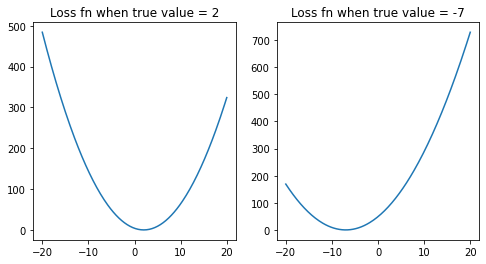

In [2]:
tvec1 = np.linspace(-20,20,201)
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.plot(tvec1, (tvec1-2)**2)
plt.title('Loss fn when true value = 2')

plt.subplot(1,2,2)
plt.plot(tvec1, (tvec1-(-7))**2)
plt.title('Loss fn when true value = -7');


### Example of classification (cross-entropy) loss function

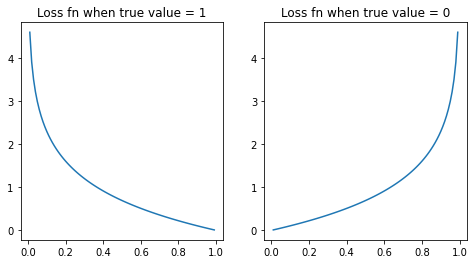

In [3]:
tvec = np.linspace(.01,.99,99)
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.plot(tvec, np.log(1/tvec))
plt.title('Loss fn when true value = 1')

plt.subplot(1,2,2)
plt.plot(tvec, np.log(1/(1-tvec)))
plt.title('Loss fn when true value = 0');


## Detailed steps
- Let $M_0$ be the current model
- Let $y_0$ be the current model's predictions on the training set
    - These will be point estimates for regression
    - These will be predicted probabilities for classification
- Let $y_t$ be the true answers (numbers for regression, 0/1 for classification)
- Let $L(y_{true}, y_{pred})$ be the loss function.
- Let $L^{\prime}_{y_{true}}(y_{pred}) = \frac{\partial}{\partial y_{pred}}(L(y_{true}, y_{pred}))$
- Let $z = L^{\prime}_{y_t}(y_1)$ -- i.e. the derivative of the loss function (with respect to the prediction) evaluated at each pair of (true, predicted) values.
- Finally, fit a decision tree that tries to predict $z$ using your predictors $X$.
    - Call the resulting tree $T_1$.
- Let $M_1 = M_0 + \epsilon T_1$ (epsilon is the "learning rate")
- Repeat with $M_1$ as the current model to build $T_2$  (etc. etc.)


### Alternate interpretation: 
- We are doing "gradient descent" by building trees

## Let's play with some data

We'll return to the games from the NBA, predicting the winner from team statistics (not including points). 

In [4]:
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import log_loss, roc_auc_score, accuracy_score
from sklearn.model_selection import train_test_split

In [5]:
df_nba = pd.read_csv('data/games.csv')
df_nba.dropna(inplace=True)
df_nba.shape

(23096, 21)

In [6]:
df_nba.sample(5)

,GAME_DATE_EST,GAME_ID,GAME_STATUS_TEXT,HOME_TEAM_ID,VISITOR_TEAM_ID,SEASON,TEAM_ID_home,PTS_home,FG_PCT_home,FT_PCT_home,...,AST_home,REB_home,TEAM_ID_away,PTS_away,FG_PCT_away,FT_PCT_away,FG3_PCT_away,AST_away,REB_away,HOME_TEAM_WINS
804,2014-04-02,21301121,Final,1610612748,1610612749,2013,1610612748,96.0,0.506,0.643,...,22.0,35.0,1610612749,77.0,0.438,1.000,0.222,18.0,42.0,1
12966,2005-11-02,20500015,Final,1610612760,1610612746,2005,1610612760,93.0,0.413,0.680,...,21.0,36.0,1610612746,101.0,0.500,0.731,0.333,23.0,42.0,0
1574,2013-12-14,21300343,Final,1610612764,1610612746,2013,1610612764,97.0,0.494,0.700,...,21.0,33.0,1610612746,113.0,0.565,0.839,0.429,27.0,34.0,0
20236,2016-10-29,21600031,Final,1610612749,1610612751,2016,1610612749,110.0,0.466,0.833,...,25.0,44.0,1610612751,108.0,0.440,0.821,0.324,23.0,45.0,1
8671,2008-11-03,20800046,Final,1610612742,1610612739,2008,1610612742,81.0,0.408,0.769,...,16.0,35.0,1610612739,100.0,0.443,0.781,0.357,19.0,52.0,0


In [7]:
df_nba.columns

Index(['GAME_DATE_EST', 'GAME_ID', 'GAME_STATUS_TEXT', 'HOME_TEAM_ID',
       'VISITOR_TEAM_ID', 'SEASON', 'TEAM_ID_home', 'PTS_home', 'FG_PCT_home',
       'FT_PCT_home', 'FG3_PCT_home', 'AST_home', 'REB_home', 'TEAM_ID_away',
       'PTS_away', 'FG_PCT_away', 'FT_PCT_away', 'FG3_PCT_away', 'AST_away',
       'REB_away', 'HOME_TEAM_WINS'],
      dtype='object')

In [8]:
feat_1 = ['FG_PCT_home','FT_PCT_home', 'FG_PCT_away', 'FT_PCT_away']
feat_2 = ['FG_PCT_home','FT_PCT_home', 'FG3_PCT_home', 'AST_home', 'REB_home', 
        'FG_PCT_away', 'FT_PCT_away', 'FG3_PCT_away', 'AST_away', 'REB_away']


In [9]:
X = df_nba.iloc[:,:-1]  # everything except winner
y = df_nba.HOME_TEAM_WINS 

In [10]:
X_train_full, X_test, y_train_full, y_test = train_test_split(X,y,test_size = 2000, random_state=0)

In [11]:
X_train_full.columns

Index(['GAME_DATE_EST', 'GAME_ID', 'GAME_STATUS_TEXT', 'HOME_TEAM_ID',
       'VISITOR_TEAM_ID', 'SEASON', 'TEAM_ID_home', 'PTS_home', 'FG_PCT_home',
       'FT_PCT_home', 'FG3_PCT_home', 'AST_home', 'REB_home', 'TEAM_ID_away',
       'PTS_away', 'FG_PCT_away', 'FT_PCT_away', 'FG3_PCT_away', 'AST_away',
       'REB_away'],
      dtype='object')

In [12]:
n_train_pts = 2000
X_train_1 = X_train_full.iloc[:n_train_pts].loc[:, feat_1]
y_train_1 = y_train_full.iloc[:n_train_pts]
X_test_1 = X_test.loc[:, feat_1]

In [13]:
## For reference, lets redo the random forest

In [14]:
rf1 = RandomForestClassifier(n_estimators=1000)
rf1

RandomForestClassifier(n_estimators=1000)

In [15]:
rf1.fit(X_train_1, y_train_1)

RandomForestClassifier(n_estimators=1000)

In [16]:
prob_preds_rf1 = rf1.predict_proba(X_test_1)[:,1]

In [17]:
log_loss(y_test, prob_preds_rf1), roc_auc_score(y_test, prob_preds_rf1)

(0.44400300336619236, 0.8691195899391264)

In [18]:
hard_preds_rf1 = (prob_preds_rf1 > .5).astype(int)

In [19]:
accuracy_score(y_test, hard_preds_rf1)

0.794

In [20]:
## now let's try a gb model

In [21]:
gb1 = GradientBoostingClassifier(max_depth=2, 
                                 n_estimators=100, learning_rate=.1)
gb1

GradientBoostingClassifier(max_depth=2)

In [22]:
gb1.fit(X_train_1, y_train_1)

GradientBoostingClassifier(max_depth=2)

In [23]:
prob_preds_gb1 = gb1.predict_proba(X_test_1)[:,1]

In [24]:
log_loss(y_test, prob_preds_gb1), roc_auc_score(y_test, prob_preds_gb1)

(0.416161505673597, 0.8859701108769819)

In [25]:
hard_preds_gb1 = (prob_preds_gb1 > .5).astype(int)

In [26]:
accuracy_score(y_test, hard_preds_gb1)

0.802

#### Now let's repeat with the bigger feature set

In [27]:
X_train_2 = X_train_full.iloc[:n_train_pts].loc[:, feat_2]
y_train_2 = y_train_full.iloc[:n_train_pts]
X_test_2 = X_test.loc[:, feat_2]

In [28]:
rf2 = RandomForestClassifier(n_estimators=1000)
rf2.fit(X_train_2, y_train_2)

RandomForestClassifier(n_estimators=1000)

In [29]:
prob_preds_rf2 = rf2.predict_proba(X_test_2)[:,1]

In [30]:
log_loss(y_test, prob_preds_rf2), roc_auc_score(y_test, prob_preds_rf2)

(0.37263690458053567, 0.914935259047428)

In [31]:
hard_preds_rf2 = (prob_preds_rf2>.5).astype(int)

In [32]:
accuracy_score(y_test, hard_preds_rf2)

0.8375

In [33]:
gb2 = GradientBoostingClassifier(max_depth=2, n_estimators=100, learning_rate=.1)
gb2.fit(X_train_2, y_train_2)

GradientBoostingClassifier(max_depth=2)

In [34]:
prob_preds_gb2 = gb2.predict_proba(X_test_2)[:,1]

In [35]:
log_loss(y_test, prob_preds_gb2), roc_auc_score(y_test, prob_preds_gb2)

(0.36675514004888876, 0.9155806826543582)

In [36]:
hard_preds_gb2 = (prob_preds_gb2>.5).astype(int)

In [37]:
accuracy_score(y_test, hard_preds_gb2)

0.833

## Gradient Boosting vs Random Forest
- Typically, Gradient Boosting can outperform Random Forests by a small, but not insignificant amount.
- However, Gradient Boosting requires much more "parameter tuning" to get the best performance
- For Random Forest, can usually use 1K or 2K trees and do well.  The only "major" parameter is the `max_features` and the default is usually reasonable.
- For Gradient Boosting, parameter tuning is considerably more complicated.
- Random Forests tend to be less "well-calibrated" than GB.  That means that the log_loss of random forests might be bad even when the AUROC or Accuracy are still reasonably good.

### Major parameters to tune for Gradient Boosting
- `max_depth`: How deep to build the trees.  This is a very important parameter and performance may change dramatically for different values.  Larger values are more likely to overfit, smaller values more likely to underfit.  I've worked on problems where max_depth was 10 or even higher for best performance.

- `learning_rate`, `n_estimators`: These parameters are also very important and interact highly with one another (and with `max_depth`).  Typically, the smaller your "step_size" (learning_rate), the more steps you will need to take to reach maximum performance. However, unlike random forests, if you continue to build trees in boosting, you will start overfitting, and performance (measured on the test set) will get worse.



The best way to deal with `learning_rate` and `n_estimators` is to use a "validation set".  That is, take some data (that is not in the training set) and evaluate the performance of the model periodically as it trains.  When performance starts getting worse on the validation set, then stop.

In theory, you should not use the test set as your validation set, because you will be overstating your performance a bit.  (Since you will be choosing the moment of peak performance on that test set to stop).  In practice, this is usually not such a big deal.  It is also fine just to set aside some data out of the training set.  The validation set does not need to be huge, and it is not crucial to stop at the exact perfect moment -- you just want to be in the right neighborhood.

### Sklearn early stopping
in version 0.20 (Sep 2018), sklearn added support for early stopping via `validation_fraction` and `n_iter_no_change`.  Unfortunately, it does not output the loss values on the validation set, so it is hard to truly see it in action.  Also, it does not support passing a separate validation set.  We will revisit early stopping when we explore the other boosting packages.

- `validation_fraction`: fraction of data to use for validation
- `n_iter_no_change`: Compare current iteration to the value $x$ trees ago to decide whether to stop or not

In [38]:
# Let's run with early stopping
# We can make the number of trees large and just rely on early stopping
# We can also make the learning rate small to be on the safe side
gb3 = GradientBoostingClassifier(max_depth=2, 
                                 n_estimators=5000, 
                                 learning_rate=.01,
                                validation_fraction=.1,
                                n_iter_no_change=20,
                                verbose=2)
gb3.fit(X_train_2, y_train_2)

      Iter       Train Loss   Remaining Time 
         1           1.3593            9.23s
         2           1.3533           10.97s
         3           1.3474           10.56s
         4           1.3417           10.55s
         5           1.3361           10.56s
         6           1.3306           10.57s
         7           1.3252           10.61s
         8           1.3199           10.51s
         9           1.3148           10.43s
        10           1.3096           10.35s
        11           1.3046           10.31s
        12           1.2997           10.31s
        13           1.2948           10.26s
        14           1.2901           10.27s
        15           1.2854           10.32s
        16           1.2809           10.29s
        17           1.2763           10.25s
        18           1.2719           10.26s
        19           1.2675           10.27s
        20           1.2632           10.29s
        21           1.2589           10.29s
        2

/Users/brianlucena/.pyenv/versions/3.7.3/envs/mypy373/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  "X does not have valid feature names, but"


       114           1.0249            8.64s
       115           1.0233            8.66s
       116           1.0217            8.66s
       117           1.0203            8.65s
       118           1.0188            8.65s
       119           1.0172            8.66s
       120           1.0157            8.66s
       121           1.0143            8.65s
       122           1.0129            8.64s
       123           1.0113            8.63s
       124           1.0098            8.62s
       125           1.0082            8.62s
       126           1.0068            8.64s
       127           1.0053            8.66s
       128           1.0040            8.65s
       129           1.0026            8.64s
       130           1.0013            8.63s
       131           0.9998            8.64s
       132           0.9983            8.63s
       133           0.9969            8.62s
       134           0.9956            8.62s
       135           0.9942            8.62s
       136

GradientBoostingClassifier(learning_rate=0.01, max_depth=2, n_estimators=5000,
                           n_iter_no_change=20, verbose=2)

In [39]:
prob_preds_gb3 = gb3.predict_proba(X_test_2)[:,1]

In [40]:
log_loss(y_test, prob_preds_gb3), roc_auc_score(y_test, prob_preds_gb3)

(0.35898655670399043, 0.9166980232791491)

NOTE: When comparing boosting models, I put more credence in the log_loss values then the ROC or Accuracy scores

In [41]:
hard_preds_gb3 = (prob_preds_gb3>.5).astype(int)

In [42]:
accuracy_score(y_test, hard_preds_gb3)

0.835

## Exercise
- Write a loop to find the "best" `max_depth` value (checking a range between 1 and 8) for this problem, with `learning_rate` = .01 and using early stopping.
- Measure "best" performance by the log_loss on the test set.
- Rerun your code on training sets of size 2000, 5000, 10000, 15000 and compare the results.

### Pseudocode
- log_loss_values = np.zeros(8)
- for curr_max_depth in range(1,9):
    - train gbmodel using early stopping and curr_max_depth
    - make predictions on test set
    - log_loss_values[i] = log loss of current model on test set
- Find the min log_loss and the associated max_depth value
- plot max_depth vs test log_loss
    